#### Time series data manipulation in pandas

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 - pd.Timestamp
 - pd.date_range
 - pd.to_datetime

In [2]:
# Create the range of dates here
seven_days = pd.date_range(start='2017-1-1',periods=7)

# Iterate over the dates and print the number and name of the weekday
for day in seven_days:
    print(day.dayofweek, day.day_name())

6 Sunday
0 Monday
1 Tuesday
2 Wednesday
3 Thursday
4 Friday
5 Saturday


In [3]:
etfs = pd.read_csv('ml/ml_assets/etfs.csv',index_col='Dates')
etfs.index = pd.to_datetime(etfs.index)
swda = etfs[['SWDA']]

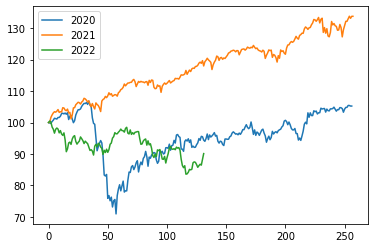

In [4]:
# Create dataframe prices here
prices = pd.DataFrame()

# Select data for each year and concatenate with prices here 
for year in ['2020', '2021','2022']:
    price_per_year = swda.loc[year, ['SWDA']].reset_index(drop=True)
    price_per_year.rename(columns={'SWDA': year}, inplace=True)
    prices = pd.concat([prices, price_per_year], axis=1)

# Plot normalized prices
prices.div(prices.loc[0]).mul(100).plot()
plt.show()

In [117]:
prices.head()

,2020,2021,2022
0,56.71,59.31,79.16
1,56.63,59.38,79.53
2,56.54,60.27,79.27
3,56.90,60.74,78.03
4,57.13,61.12,77.49


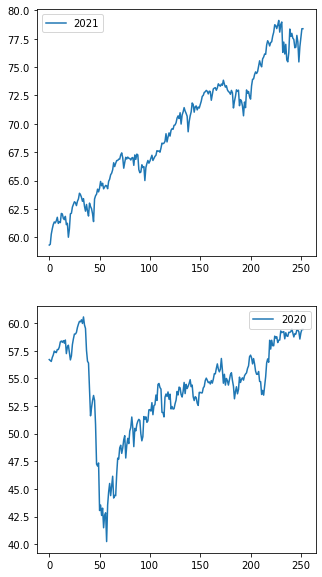

In [6]:
# Plot the time series in each dataset
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
prices.loc[:252].plot(y='2021', ax=axs[0])
prices.loc[:252].plot(y='2020', ax=axs[1])
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2019-07-30 to 2022-07-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SWDA    756 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB
None


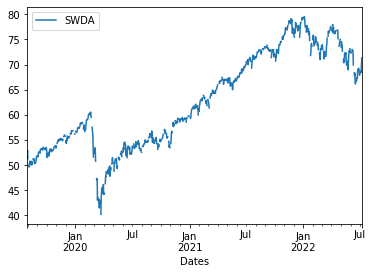

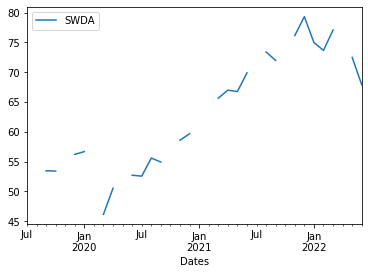

In [7]:
# Inspect data
print(swda.info())

# Set data # set the frequency to calendar daily
swda.asfreq('D').plot(subplots=True)
plt.show()

# Set frequency to monthly
swda.asfreq('M').plot(subplots=True)
plt.show()


----------
#### Random walk

 - using numpy and scipy
 - compare random walk with asset returns

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


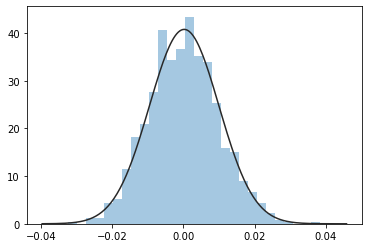

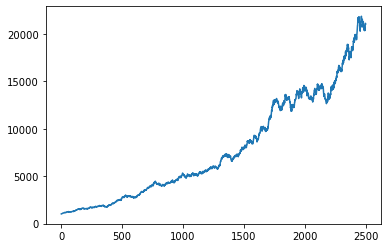

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


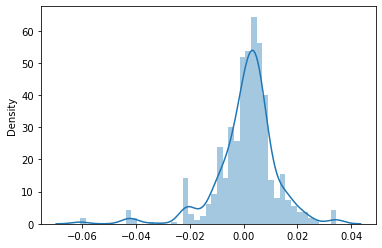

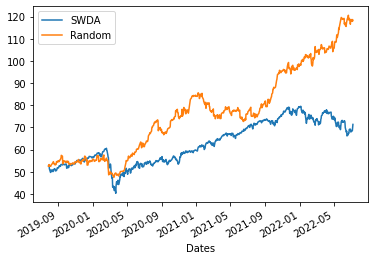

In [113]:
from numpy.random import normal, seed, choice
from scipy.stats import norm
import seaborn as sns

seed(42)

random_returns = normal(loc=0, scale=0.01, size=1000)
sns.distplot(random_returns, fit=norm, kde=False)
plt.show()

# Create random_walk
random_walk = normal(loc=.001, scale=0.01, size=2500)

# Create random_prices
random_prices = pd.Series(random_walk).add(1).cumprod()

# Plot random_prices here
random_prices.mul(1000).plot()
plt.show()


# Calculate daily_returns here
daily_returns = swda.pct_change().dropna()

# Get n_obs
n_obs = daily_returns.count()[0]

# Create random_walk
random_walk = choice(daily_returns.values.ravel(), size=n_obs)

# Convert random_walk to pd.series
random_walk = pd.Series(random_walk, index = daily_returns.index)

# Plot random_walk distribution
sns.distplot(random_walk)
plt.show()

swda['Random'] = random_walk.add(1)
swda.iloc[0,1] = swda.iloc[0,0].copy()
swda['Random'] = swda['Random'].cumprod()
swda.plot()
plt.show()

---------
#### Time series analysis

 - autocorrelation
 - white noise
 - random walk
 - AR model
 - MA model
 - ARMA model
 - Cointegration
 - ARIMA model

1. autocorrelation

 - null hypothesis is that our correlation at lag k, rk, is equal to zero at the 5% level
 - alpha = 5% means there's a 5% chance that if the true autocorrelation is 0 it falls outside the band
 - we have evidence to reject the null if values fall outside the band
 - but beware we should expect 5% of these lags to exceed these values anyway
 - further we are displaying correlated values and hence if one lag falls outside of these boundaries then proximate sequential values are more likely to do so as well
 - in practice we are looking for lags that may have some underlying reason for exceeding the 5% level
 - even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is 1/N where N is the number of observations, so if N = 100, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is ±1.96/N. This approximation only holds when the true autocorrelations are all zero.

The autocorrelation of returns is -0.05
The approximate confidence interval is +/- 0.33

 [ 1.         -0.04499046 -0.16436617 -0.04057022  0.19759938 -0.0291837
 -0.19551148  0.34890656 -0.13510199 -0.0376401  -0.1210332   0.0475642
 -0.08562517 -0.09821601 -0.03358353 -0.12417783]


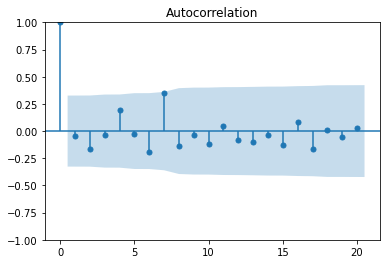

In [103]:
# Import the plot_acf module from statsmodels and sqrt from math
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt

# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf


# Resample
swda.index = pd.to_datetime(swda.index)
ret_swda = swda.SWDA.resample(rule='M').last().pct_change().dropna()

# Compute and print the autocorrelation
autocorrelation = ret_swda.autocorr()
print("The autocorrelation of returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(ret_swda)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))


# Compute the acf array
acf_array = acf(ret_swda)
print('\n',acf_array)

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(ret_swda, alpha=0.05, lags=20)
plt.show()

# Plot the acf function without bands
# plot_acf(ret_swda, alpha=1)
# plt.show()

2. White noise

 - any process with constant mean, constant variance and zero autocorrelations at all lags (e.g. discrete white noise = process with mean equal to zero, variance equal to σ^2 and no serial correlation)
 - Gaussian white noise = process where the data has a normal distribution
 - in particular, if the values wt are drawn from a standard normal distribution (i.e. wt ∼ N (0, σ^2)), then the series is known as Gaussian white noise

The mean is 0.017 and the standard deviation is 0.050


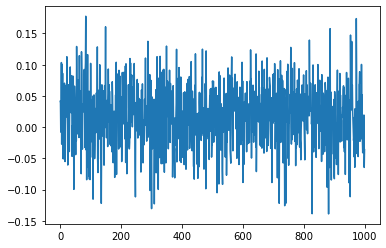

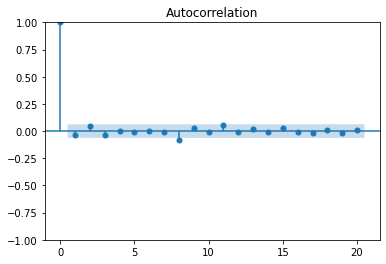

In [116]:
# Simulate white noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

# Plot returns series
plt.plot(returns)
plt.show()

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20)
plt.show()

3. random walk

 - when the change (difference) in a process's values is a white noise, then the series is a random walk
     - Pt - Pt_1 = Et
     - if prices are in logarithmic, then the difference in log prices is actually the asset's returns
     - if stock prices follow a random walk, then stock returns are a white noise process
 - if prices are a random walk with a drift μ, the returns are still white noise but with non-zero mean (Pt - Pt_1 = μ + Et)
 - to test if a series is a random walk, we can regress current prices on lagged prices
     - Pt = a + b x Pt_1 + Et
     - if the slope coefficient is not significantly different from 1, then you cannot reject the Ho: b=1, i.e. the series may be a random walk process
     - if the slope coeff is significantly less than 1, then you can reject the null hypothesis (H1: b<1)
 - alternatively you can regress the difference in prices on the lagged prices
     - Pt - Pt_1 = a + b x Pt_1 + Et
     - then the null becomes Ho: b = 0 (Dickey - Fuller test)
     - if there are more lagged prices then it is the Augmented DF test

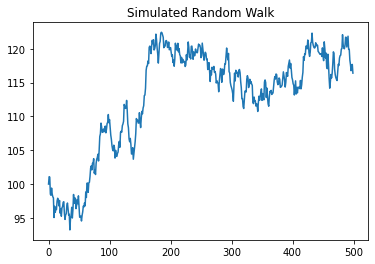

In [134]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1.0, size=500)

# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0

# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show()

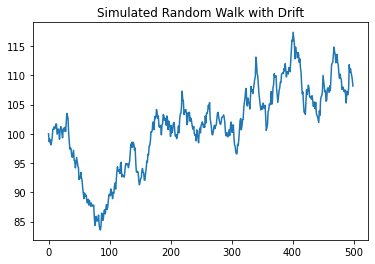

In [135]:
# Generate 500 random steps 
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show()

In [132]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

display(help(adfuller))

# Run the ADF test on the price series and print out the p-value
results = adfuller(swda.SWDA)
display(results)
print('The p-value of the test on prices is: ' + str(results[1]))


# Run the ADF test on the return series and print out the p-value
ret_results = adfuller(swda.SWDA.pct_change().dropna())
display(ret_results)
print('The p-value of the test on returns is: ' + str(ret_results[1]))

# The p-value is extremely small, so we can easily reject the hypothesis
# that returns are a random walk at all levels of significance.


Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
      

None

(-1.1152175568591574,
 0.7089653246357551,
 0,
 755,
 {'1%': -3.4390409569041207,
  '5%': -2.865375732701395,
  '10%': -2.568812543748081},
 1611.472272494829)

The p-value of the test on prices is: 0.7089653246357551


(-7.149116833523421,
 3.1750997636623505e-10,
 17,
 737,
 {'1%': -3.4392539652094154,
  '5%': -2.86546960465041,
  '10%': -2.5688625527782327},
 -4373.553860689135)

The p-value of the test on returns is: 3.1750997636623505e-10


4. AR

- Stationarity
 
     - if a series is non-stationary, then it becomes difficult to model as there are many time-varying parameters to estimate

     - examples of non-stationary series are random walks, seasonal series, white noise with increasing mean

     - Strong: joint distribution of observations do not depend on time
         - a time series model, {xt}, is strictly stationary if the joint statistical distribution of the elements xt1, ..., xtn is the same as that of xt1+m, ..., xtn+m, ∀ t i,m.
         - another def = the distribution of a time series is unchanged for any arbitrary shift in time

     - Weak: mean, variance and autocorrelation are time invariant

     - non-stationary series can be transformed to stationary by taking logs or / and differences
      
     - so for a series to be stationary, it must have zero trend, constant variance (i.e. average distance of data points from the zero line isn't changing with time) and constant autocorrelation (how each value in the series is related to its neighbours isn't changing)
     
     
- The autoregressive model is simply an extension of the random walk that includes terms further back in time. The structure of the model is linear, that is the model depends linearly on the previous terms, with coefficients for each term. This is where the "regressive" comes from in "autoregressive". It is essentially a regression model where the previous terms are the predictors.
 
     - xt = α1xt−1 +...+αpxt−p +wt , where {wt} is white noise and αi ∈ R, with αp != 0 for a p-order autoregressive process.
     - in an AR(1) φ or α can be interpreted as mean reverting (if φ<1) or momentum (if φ>1) dynamics, in the former case negative values are followed by positive and vice versa, while in the latter positive values are followed by positive ones (and vice versa)
     - if the AR parameter, ϕ = + 0.9, the first-lag autocorrelation will be 0.9, the second-lag will be (0.9)^2 = 0.81, the third-lag will be (0.9)^3 = 0.729, etc. A smaller AR parameter will have a steeper decay, and for a negative AR parameter, say -0.9, the decay will flip signs, so the first-lag autocorrelation will be -0.9, the second-lag will be (−0.9)^2 = 0.81, the third-lag will be (−0.9)^3 = −0.729, etc.
     - not necessarily stationary model, depends on the parameters - need to solve the characteristic equation i.e. the model written in backward shift form and set to zero - we also need all of the roots to exceed the unity
     - mean of an AR(p) series is zero
     - auto-covariances and auto-correlations are given by recursive functions known as Yule-Walker equations
 

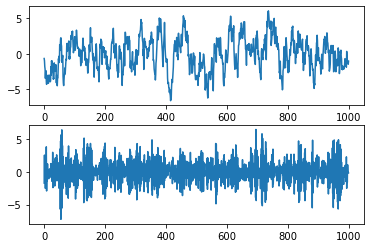

In [145]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: AR parameter = +0.9 (input param has the opposite sign than what's intended)
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

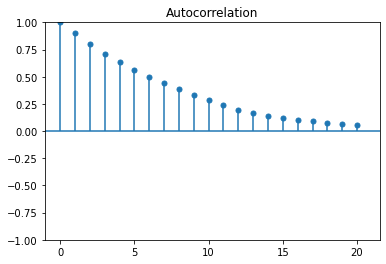

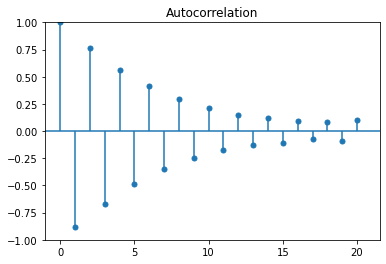

In [146]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show()

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1414.205
Date:                Thu, 29 Dec 2022   AIC                           2834.409
Time:                        22:20:28   BIC                           2849.132
Sample:                             0   HQIC                          2840.005
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1055      0.306     -0.344      0.731      -0.706       0.495
ar.L1          0.8973      0.014     62.073      0.000       0.869       0.926
sigma2         0.9889      0.042     23.573      0.0

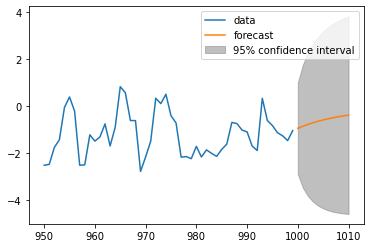

In [157]:
# Import the ARIMA and plot_predict from statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Fit an AR(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(1,0,0))
res = mod.fit()
simulated_data_1 = pd.Series(simulated_data_1)
simulated_data_1.name = 'data'

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for phi
print("When the true phi=0.9, the estimate of phi is:")
print(res.params[1])

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

In [170]:
import pandas_datareader as pdr

interest_rate_data = pdr.fred.FredReader('DGS10',start='1950-01-01').read().ffill()

In [179]:
interest_rate_data_monthly = interest_rate_data.resample('M').last()

In [186]:
interest_rate_data_monthly_shifted = interest_rate_data_monthly.shift(1).dropna()

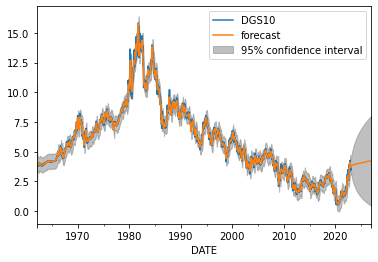

In [187]:
# Forecast interst rates using an AR(1) model
mod = ARIMA(interest_rate_data_monthly, order=(1,0,0))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
interest_rate_data.plot(ax=ax)
plot_predict(res, start=0, end='2027', ax=ax)
plt.show()

Sometimes it is difficult to distinguish between a time series that is slightly mean reverting and a time series that does not mean revert at all, like a random walk. Compare the ACF for the slightly mean-reverting interest rate series with a simulated random walk with the same number of observations.

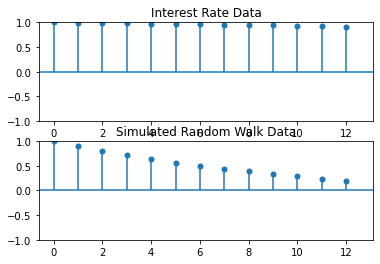

In [188]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot the interest rate series and the simulated random walk series side-by-side
fig, axes = plt.subplots(2,1)

# Plot the autocorrelation of the interest rate series in the top plot
fig = plot_acf(interest_rate_data_monthly, alpha=1, lags=12, ax=axes[0])

# Plot the autocorrelation of the simulated random walk series in the bottom plot
fig = plot_acf(simulated_data_1, alpha=1, lags=12, ax=axes[1])

# Label axes
axes[0].set_title("Interest Rate Data")
axes[1].set_title("Simulated Random Walk Data")
plt.show()

One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). We will simulate two time series, an AR(1) and an AR(2), and calculate the sample PACF for each. We notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the sample PACF should have significant lag-1 and lag-2 values, and zeros after that.

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


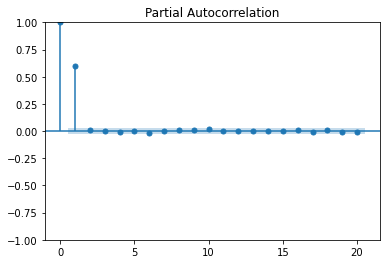

/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


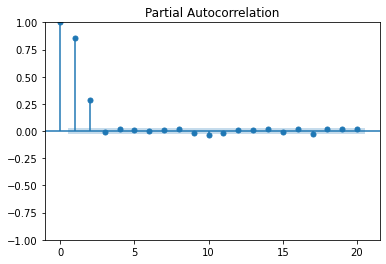

In [189]:
# Import the modules for simulating data and for plotting the PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf

# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20)
plt.show()

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)


# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20)
plt.show()

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model.

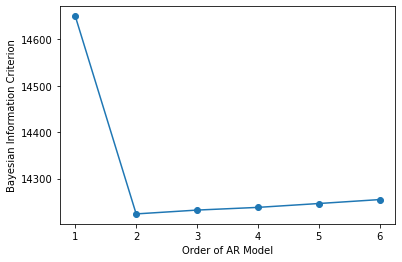

In [190]:
# Import the module for estimating an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(simulated_data_2, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

5. MA models

 - a Moving Average model is similar to an Autoregressive model, except that instead of being a linear combination of past time series values, it is a linear combination of the past white noise terms
 - this means that the MA model sees such random white noise "shocks" directly at each current value of the model, in contrast to an AR(p) model, where the white noise "shocks" are only seen indirectly, via regression onto previous terms of the series
 - a key difference is that the MA model will only ever see the last q shocks for any particular MA(q) model, whereas the AR(p) model will take all prior shocks into account, albeit in a decreasingly weak manner
 - a time series model, {xt}, is a moving average model of order q, MA(q), if: xt =wt +β1wt−1 +...+βqwt−q where {wt} is white noise with E(wt) = 0 and variance σ^2
 - in a MA(1), xt = μ + wt + b1wt-1, a negative b1 parameter would be interpreted as an one-period mean reversion and a positive b1 parameter as a one-period momentum
 - one big difference you will see between out-of-sample forecasts with an MA(1) model and an AR(1) model is that the MA(1) forecasts more than one period in the future are simply the mean of the sample, in a MA(1) model all forecasts beyond the one-step ahead forecasts will be the same

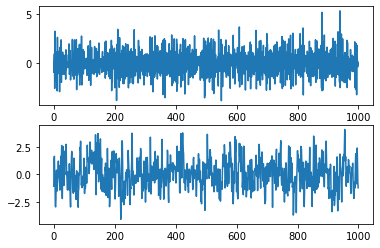

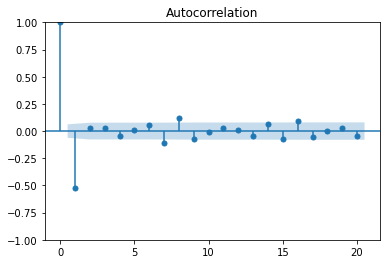

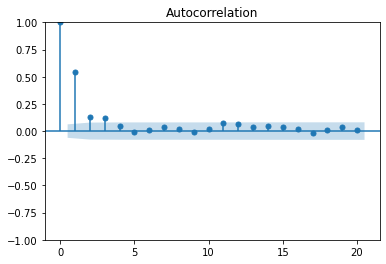

In [198]:
# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show()

# Plot 1: MA parameter = -0.9
plot_acf(simulated_data_1, lags=20)
plt.show()

# Plot 2: MA parameter = 0.9
plot_acf(simulated_data_2, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1394.945
Date:                Fri, 30 Dec 2022   AIC                           2795.889
Time:                        10:53:57   BIC                           2810.613
Sample:                             0   HQIC                          2801.485
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.828      0.408      -0.004       0.009
ma.L1         -0.8994      0.013    -67.844      0.000      -0.925      -0.873
sigma2         0.9516      0.043     22.074      0.0

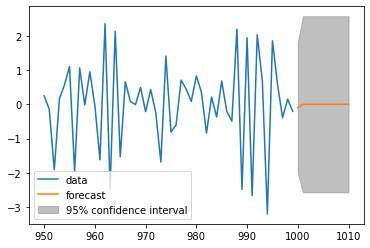

In [199]:
# Fit an MA(1) model to the first simulated data
mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta is:")
print(res.params[1])

# Forecast the first MA(1) model
simulated_data_1 = pd.Series(simulated_data_1)
simulated_data_1.name = 'data'

mod = ARIMA(simulated_data_1, order=(0,0,1))
res = mod.fit()

# Plot the data and the forecast
fig, ax = plt.subplots()
simulated_data_1.loc[950:].plot(ax=ax)
plot_predict(res, start=1000, end=1010, ax=ax)
plt.show()

6. ARMA

 - an AR(1) model is equivalent to a MA(q) model where q=infinity, as an AR(1) model includes all error term lags
 - identifying whether a time series is stationary or non-stationary is very important, if it is stationary you can use ARMA models to predict the next values of the time series, if it is non-stationary then you cannot use ARMA models, however, you can often transform non-stationary time series to stationary ones

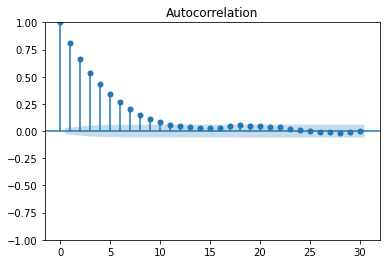

In [202]:
# Build a list MA parameters
ma = [.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show()

7. Cointegration

 - a linear combination of two series that are random walks might be a stationary process, which means it may be forecastable

In [219]:
comm = pdr.fred.FredReader(['DHHNGSP','DHOILNYH'],start='1999-01-01').read().ffill().dropna()
comm.head()

,DHHNGSP,DHOILNYH
DATE,,
1999-01-04,2.10,0.346
1999-01-05,2.05,0.338
1999-01-06,2.04,0.354
1999-01-07,1.91,0.352
1999-01-08,1.90,0.360


In [209]:
NG = comm['DHHNGSP'].copy()
HO = comm['DHOILNYH'].copy()

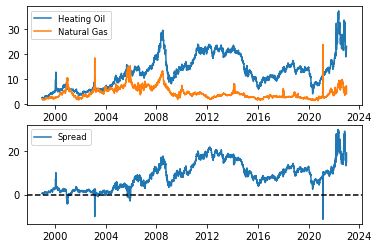

In [210]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25 *HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

In [216]:
# Compute the ADF for HO and NG
result_HO = adfuller(HO)
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG)
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread - ORIGINAL: result_spread = adfuller(7.25 * HO - NG)
result_spread = adfuller(HO - NG)
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.18519914358007838
The p-value for the ADF test on NG is  0.000862173075410641
The p-value for the ADF test on the spread is  0.0012847831049422143


Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,-1). In other words, we took the difference between the two series (after doing a units conversion).

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient b, then the cointegration vector is simply (1,−b). Then perform the ADF test on BTC −b * ETH.

In [236]:
crypto = pdr.fred.FredReader(['CBBTCUSD','CBETHUSD'],start='2010-01-01').read().ffill().dropna()
print(crypto.head())

ETH = crypto['CBETHUSD'].copy()
BTC = crypto['CBBTCUSD'].copy()

# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
print('param', b)
adf_stats = adfuller(BTC - b*ETH['CBETHUSD'])
print("The p-value for the ADF test is ", adf_stats[1])

            CBBTCUSD  CBETHUSD
DATE                          
2016-05-18    455.56     13.18
2016-05-19    438.38     14.90
2016-05-20    445.65     14.17
2016-05-21    446.28     14.17
2016-05-22    442.48     14.17
param 13.745215762128876
The p-value for the ADF test is  0.007868942832149449


In [239]:
temp_NY = pd.read_csv('assets/time_series/NOAA_TAVG.csv',index_col='DATE')
temp_NY.head()

,TAVG
DATE,
1870,53.8
1871,51.3
1872,51.3
1873,50.9
1874,51.3


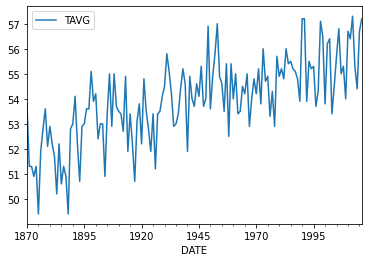

The p-value for the ADF test is  0.5832938987871124


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


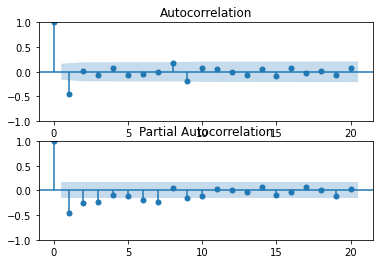

The AIC for an AR(1) is:  510.5346898733112
The AIC for an AR(2) is:  501.92741234091375


/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/lazaros/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWar

The AIC for an ARMA(1,1) is:  469.072918924161


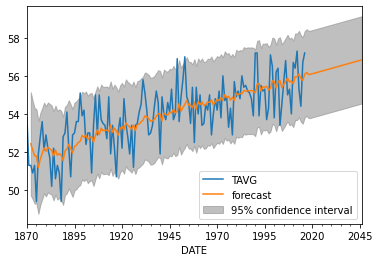

In [243]:
# --------------------------------------------------------- 1. Review
# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

# --------------------------------------------------------- 2. Transform
# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

# --------------------------------------------------------- 3. Model and evaluate
# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1,0,0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(2,0,0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(1,0,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

# --------------------------------------------------------- 4. Predict

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()

# According to the model, the temperature is expected to
# be about 0.6 degrees higher in 30 years (almost entirely due to the trend),
# but the 95% confidence interval around that is over 5 degrees.

8. ARIMA
 - issues with time series include the presence of a trend, seasonality (repeating patterns at regular intervals), cyclicality patterns (repeating patterns but no fixed period)